#Economic Recession Predict with Machine Learning 


## 1. Set Up Environment and Read Data <a id="1"></a>


In [ ]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from matplotlib import pyplot as mp
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!gdown --id 13bCxPUblmiZxA4LT4_WSxwGJ7-Fm0_RN #import Data from Google Drive
bigmacro=pd.read_csv("Macroeconomic_Variables.csv")
bigmacro=bigmacro.rename(columns={'sasdate':'Date'})
bigmacro.head(2)

Downloading...
From: https://drive.google.com/uc?id=13bCxPUblmiZxA4LT4_WSxwGJ7-Fm0_RN
To: /content/Macroeconomic_Variables.csv
100% 601k/601k [00:00<00:00, 85.1MB/s]


,Date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,...,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXMMTH,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,1/1/59,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,21.9673,37.7309,7.9964,21.2170,12.6075,30.5395,21.1480,20.2590,38.3446,80.1973,1357.0,0.333579,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,33682,...,0.61,0.88,1.53,1.54,1.64,2.39,NaN,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.0,32.5,29.01,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.074,56.918,17.791,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1,2/1/59,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,22.0826,38.0916,8.1034,21.8889,13.1882,31.0742,21.5368,20.2038,37.8223,81.4428,1421.0,0.358386,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,33798,...,0.70,1.11,1.53,1.53,1.71,2.46,NaN,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.0,32.5,29.00,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.089,56.951,17.798,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN


In [ ]:
!gdown --id 1STranfI5RYDNDNNiqe0Zr01qoX-Z2CjM
Recession_periods=pd.read_csv('Recession_Periods.csv')
Recession_periods.head()

Downloading...
From: https://drive.google.com/uc?id=1STranfI5RYDNDNNiqe0Zr01qoX-Z2CjM
To: /content/Recession_Periods.csv
100% 13.3k/13.3k [00:00<00:00, 35.4MB/s]


,Unnamed: 0,Date,Regime
0,0,1/1/59,Normal
1,1,2/1/59,Normal
2,2,3/1/59,Normal
3,3,4/1/59,Normal
4,4,5/1/59,Normal


In [ ]:
bigmacro.insert(loc=1,column="Regime", value=Recession_periods['Regime'].values) #merg file
bigmacro.head()

,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,...,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXMMTH,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,1/1/59,Normal,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,21.9673,37.7309,7.9964,21.2170,12.6075,30.5395,21.1480,20.2590,38.3446,80.1973,1357.0,0.333579,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,...,0.61,0.88,1.53,1.54,1.64,2.39,NaN,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.01,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.074,56.918,17.791,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1,2/1/59,Normal,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,22.0826,38.0916,8.1034,21.8889,13.1882,31.0742,21.5368,20.2038,37.8223,81.4428,1421.0,0.358386,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,...,0.70,1.11,1.53,1.53,1.71,2.46,NaN,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.00,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.089,56.951,17.798,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
2,3/1/59,Normal,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,22.5150,37.9113,8.1909,22.4575,13.7078,31.5410,21.8737,20.3417,38.7798,82.4769,1524.0,0.400947,68068,64267,5.6,15.3,1459,1093,1210,530,680,260346,53014,19069,704.1,3013,15259,8965,6294,...,0.33,0.81,1.19,1.19,1.33,2.05,NaN,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.97,44.7,29.6,21.3,33.2,38.3,23.0,28.9,30.7,29.6,16.100,57.022,17.785,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
3,4/1/59,Normal,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,22.6592,38.5424,8.4049,23.0777,14.1204,32.5178,22.3402,20.4243,38.6057,83.9922,1589.0,0.444973,68339,64768,5.2,14.9,1494,934,1039,408,631,246413,53321,19269,705.2,3085,15385,9077,6308,...,0.31,0.76,1.16,1.16,1.27,1.90,NaN,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,28.98,44.8,29.7,21.3,33.2,38.3,23.1,29.0,30.7,29.6,16.132,57.080,17.796,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
4,5/1/59,Normal,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,23.1204,38.5423,8.6773,23.6721,14.6095,32.8100,22.6512,20.7275,37.8658,84.9159,1655.0,0.475711,68178,64699,5.1,14.7,1479,1005,965,390,575,246952,53550,19378,710.0,3087,15487,9160,6327,...,0.43,1.06,1.45,1.41,1.47,2.06,NaN,4.3228,359.8417,2.8145,0.9630,33.3,33.3,30.9,31.5,2.97,32.9,29.04,44.9,29.7,21.4,33.3,38.4,23.2,29.1,30.7,29.6,16.140,57.175,17.777,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


## 2. Data Cleaning 

In [ ]:
#remove columns with missing observations
missing_colnames=[]
for i in bigmacro.drop(['Date','Regime'],axis=1):
    observations=len(bigmacro)-bigmacro[i].count()
    if (observations>10):
        print(i+':'+str(observations))
        missing_colnames.append(i)
 
bigmacro=bigmacro.drop(labels=missing_colnames, axis=1)

#rows with missing values
bigmacro=bigmacro.dropna(axis=0)

bigmacro.shape

PERMIT:13
PERMITNE:13
PERMITMW:13
PERMITS:13
PERMITW:13
ACOGNO:398
ANDENOx:110
TWEXMMTH:168
UMCSENTx:155
VXOCLSx:42


(718, 120)

In [ ]:
# Add lags
for col in bigmacro.drop(['Date', 'Regime'], axis=1):
    for n in [3,6,9,12,18]:
        bigmacro['{} {}M lag'.format(col, n)] = bigmacro[col].shift(n).ffill().values

# 1 month ahead prediction
bigmacro["Regime"]=bigmacro["Regime"].shift(-1)

bigmacro=bigmacro.dropna(axis=0)

In [ ]:
bigmacro.shape

(699, 710)

Augmented Dickey-Fuller Test can be used to test for stationarity in macroeconomic time series variables. We will use `adfuller` function from `statsmodels` module in Python. More information about the function can be found __[here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)__.

###stationarity

In [ ]:
#check stationarity
from statsmodels.tsa.stattools import adfuller #to check unit root in time series 
threshold=0.01 #significance level
for column in bigmacro.drop(['Date','Regime'], axis=1):
    result=adfuller(bigmacro[column])
    if result[1]>threshold:
        bigmacro[column]=bigmacro[column].diff()
bigmacro=bigmacro.dropna(axis=0)

In [ ]:
threshold=0.01 #significance level
for column in bigmacro.drop(['Date','Regime'], axis=1):
    result=adfuller(bigmacro[column])
    if result[1]>threshold:
        bigmacro[column]=bigmacro[column].diff()
bigmacro=bigmacro.dropna(axis=0)

In [ ]:
threshold=0.01 #significance level
for column in bigmacro.drop(['Date','Regime'], axis=1):
    result=adfuller(bigmacro[column])
    if result[1]>threshold:
        print(column)
bigmacro=bigmacro.dropna(axis=0)  

CES0600000008 6M lag


#### Standardize

In [ ]:
# Standardize
from sklearn.preprocessing import StandardScaler
features=bigmacro.drop(['Date','Regime'],axis=1)
col_names=features.columns

scaler=StandardScaler()
scaler.fit(features)
standardized_features=scaler.transform(features)
standardized_features.shape
df=pd.DataFrame(data=standardized_features,columns=col_names)
df.insert(loc=0,column="Date", value=bigmacro['Date'].values)
df.insert(loc=1,column='Regime', value=bigmacro['Regime'].values)
df.head()
df.shape

(697, 710)

สร้าง Label Dummy

In [ ]:
Label = df["Regime"].apply(lambda regime: 1. if regime == 'Normal' else 0.)
df.insert(loc=2, column="Label", value=Label.values)

## 3. Feature Selection with $L_1$ Penalty <a id="3"></a>

In [ ]:
# Time Series Split
df_idx = df[df.Date == '12/1/96'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]



In [ ]:
print(len(df_training_features),len(df_training_targets),len(df_targets))
print(len(df_validation_features),len(df_validation_targets),len(df_features))

435 435 697
262 262 697


In [ ]:
scoring="roc_auc"
kfold= model_selection.TimeSeriesSplit(n_splits=3)
seed=8

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C)

model=LogisticRegression(max_iter=10000,penalty='l1',solver='liblinear')
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(X=df_features,
                                                                       y=df_targets).best_estimator_

LR_penalty

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X=df_features
y=df_targets
lr_l2 = LogisticRegression(C=0.1, max_iter=10000,penalty="l1",solver='liblinear').fit(X,y)
model = SelectFromModel(lr_l2,prefit=True)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_new = model.transform(X)
X_new.shape

(697, 35)

In [ ]:
feature_name

Index(['DPCERA3M086SBEA', 'IPFPNSS', 'IPMANSICS', 'HWI', 'UNRATE', 'PAYEMS',
       'SRVPRD', 'USTPU', 'USWTRADE', 'USFIRE', 'HOUST', 'HOUSTW',
       'S&P div yield', 'TB3MS', 'TB3SMFFM', 'IPMAT 9M lag', 'IPDMAT 12M lag',
       'CLAIMSx 9M lag', 'DMANEMP 12M lag', 'USFIRE 3M lag', 'AWOTMAN 18M lag',
       'BUSLOANS 6M lag', 'S&P 500 6M lag', 'S&P div yield 3M lag',
       'TB3MS 6M lag', 'AAA 3M lag', 'TB3SMFFM 3M lag', 'T1YFFM 6M lag',
       'T5YFFM 6M lag', 'T10YFFM 6M lag', 'T10YFFM 12M lag', 'EXUSUKx 12M lag',
       'WPSID62 9M lag', 'OILPRICEx 9M lag', 'CUSR0000SAD 3M lag'],
      dtype='object')

In [ ]:
df_2=df[feature_name]
df_2.insert(loc=0, column="Date", value=df['Date'].values)
df_2.insert(loc=1, column="Regime", value=df['Regime'].values)
df_2.insert(loc=2, column="Label", value=df['Label'].values)

df_2.head()
df_2.shape

(697, 38)

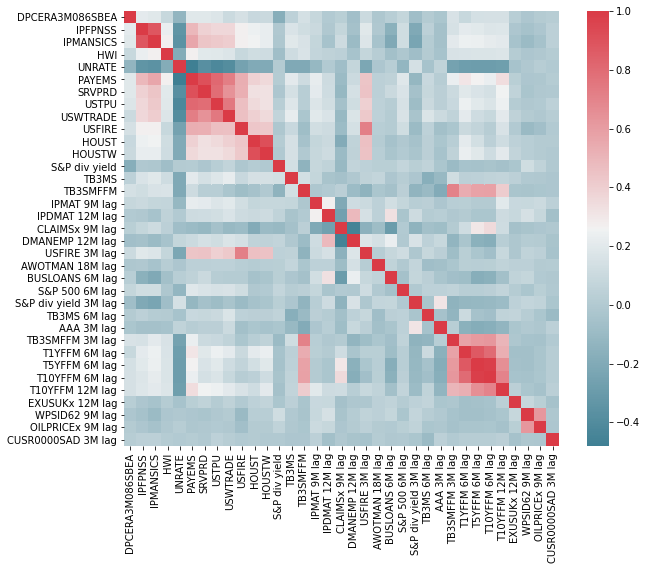

In [ ]:
corr = df_2.drop(['Date','Regime','Label'],axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

## 4. Training Algorithms on Training Dataset <a id="3"></a>

In [ ]:
df=df_2
df.shape

(697, 38)

In [ ]:
# Time Series Split
df_idx = df[df.Date == '12/1/96'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]



LR: 0.897279 (0.033442)
LR_L1: 0.934921 (0.031076)
LR_L2: 0.948832 (0.021481)
LDA: 0.858740 (0.063361)
KNN: 0.837252 (0.115853)
GB: 0.789303 (0.116154)
ABC: 0.868133 (0.045829)
RF: 0.916761 (0.039029)
XGB: 0.878555 (0.063837)


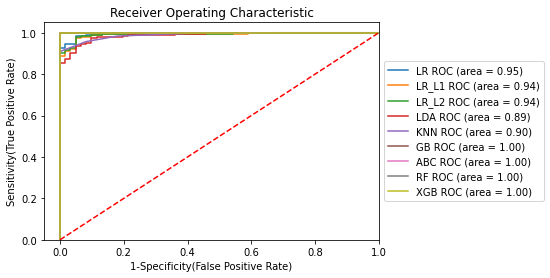

In [ ]:
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=3) 
models = []

models.append(('LR', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1',solver='liblinear')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
lb = preprocessing.LabelBinarizer()

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets,model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
warnings.filterwarnings('ignore')

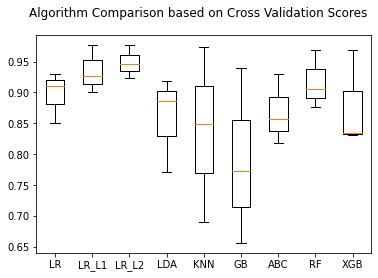

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 4. Evaluate Performances of the Algorithms on Validation Dataset <a id="4"></a>

### Logistic Regression

In [ ]:
model=LogisticRegression(C=1e09) # high penalty 
LR=model.fit(df_training_features,df_training_targets)
training_predictions=LR.predict(df_training_features)
prob_predictions = LR.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR.predict_proba(df_validation_features), axis=0)

In [ ]:
import datetime
# define periods of recession
rec_spans = []
#rec_spans.append([datetime.datetime(1957,8,1), datetime.datetime(1958,4,1)])
rec_spans.append([datetime.datetime(1960,4,1), datetime.datetime(1961,2,1)])
rec_spans.append([datetime.datetime(1969,12,1), datetime.datetime(1970,11,1)])
rec_spans.append([datetime.datetime(1973,11,1), datetime.datetime(1975,3,1)])
rec_spans.append([datetime.datetime(1980,1,1), datetime.datetime(1980,6,1)])
rec_spans.append([datetime.datetime(1981,7,1), datetime.datetime(1982,10,1)])
rec_spans.append([datetime.datetime(1990,7,1), datetime.datetime(1991,2,1)])
rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,10,1)])
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,5,1)])

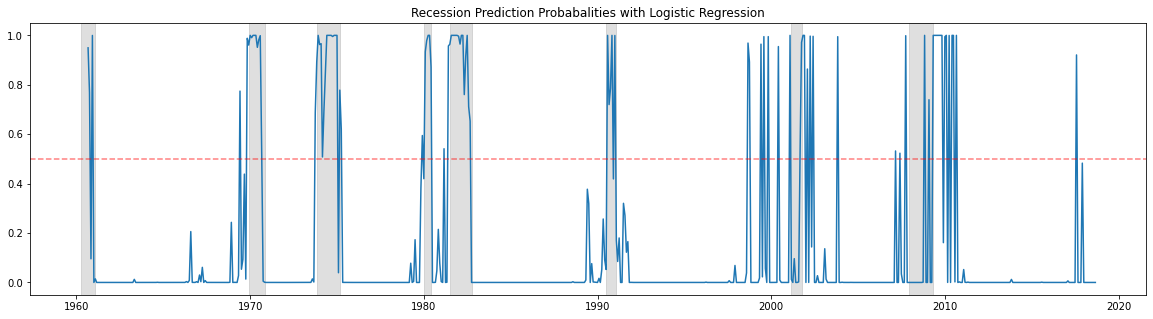

In [ ]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Logistic Regression')
mp.savefig('plot1.png',  bbox_inches='tight')
plt.show()

### Logistic Regression with Regularization

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


model=LogisticRegression(max_iter=10000)
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(df_training_features,
                                                                       df_training_targets).best_estimator_
training_predictions=LR_penalty.predict(df_training_features)

In [ ]:
prob_predictions = LR_penalty.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR_penalty.predict_proba(df_validation_features), axis=0)

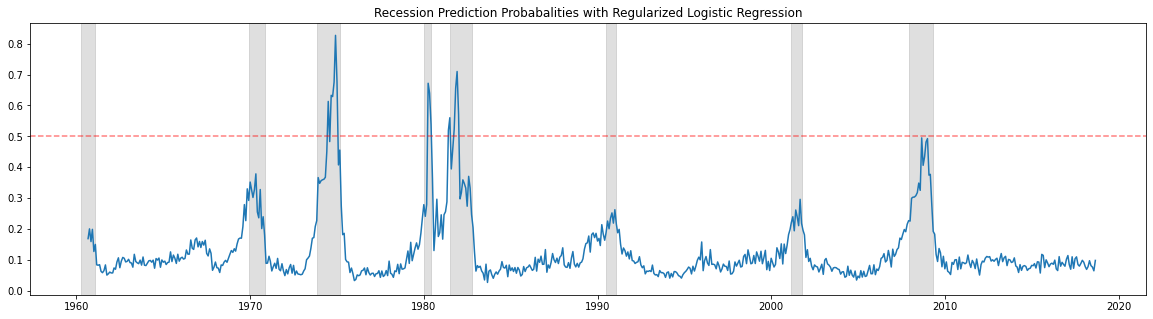

In [ ]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Regularized Logistic Regression')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()

### XGBoosting

In [ ]:
xgboost = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                                       param_grid={'booster': ['gbtree']},
                                       scoring=scoring, cv=kfold).fit(df_training_features, 
                                                                      lb.fit_transform(df_training_targets)).best_estimator_
xgboost.fit(df_training_features, df_training_targets)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
prob_predictions = xgboost.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, xgboost.predict_proba(df_validation_features), axis=0)

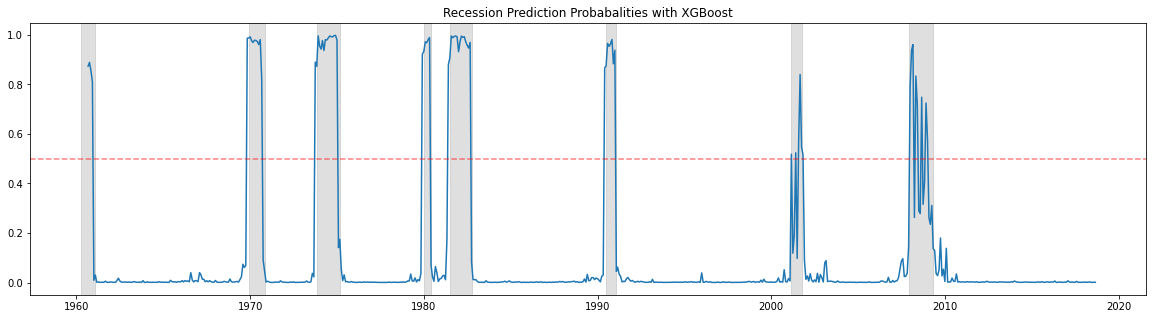

In [ ]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with XGBoost')
mp.savefig('plot3.png',  bbox_inches='tight')
plt.show()

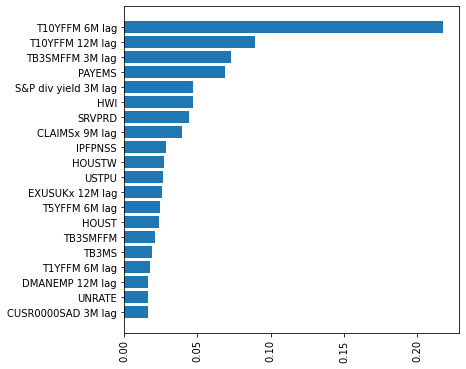

In [ ]:
# find feature importances
headers = df.drop(['Regime','Label', 'Date'], axis=1).columns.values.tolist()
xgboost_importances = pd.DataFrame(xgboost.feature_importances_, index = headers, columns = ['Relative Importance'])
_ = xgboost_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
xgboost_importances = xgboost_importances[xgboost_importances['Relative Importance']>0].iloc[:20]

# display importances in bar-chart and pie-chart
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(xgboost_importances)), width=xgboost_importances['Relative Importance'], align='center', tick_label=xgboost_importances.index)
plt.gca().invert_yaxis()
mp.savefig('feature_importance.png',  bbox_inches='tight')
plt.show()

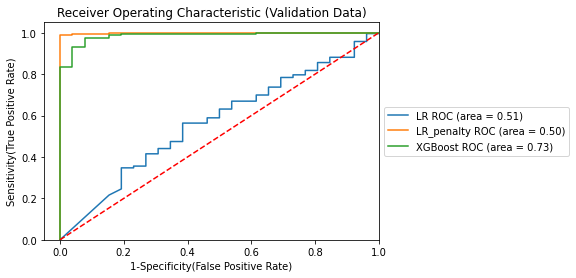

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR_penalty.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR_penalty.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, xgboost.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,xgboost.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

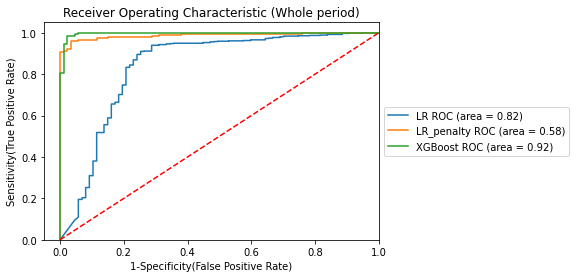

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))


fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR_penalty.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR_penalty.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, xgboost.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,xgboost.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Whole period)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC2.png',  bbox_inches='tight')
plt.show() 